# [[데이콘] 뉴스 그룹 분류 경진대회](https://dacon.io/competitions/official/235884/overview/description)
스포츠, 사회, 과학, 정치, 종교 등 20개의 카테고리의 토픽을 분류하는 대회  
대회를 시작하기 앞서 어떤 데이터가 주어졌고, 어떤 방식으로 활용할 수 있을지  
데이터를 분석하고 시각화하며 인사이트를 얻어내는 작업 필요

target : 뉴스 그룹 (20개의 그룹)
- 1 : alt.atheism
- 2 : comp.graphics
- 3 : comp.os.ms-windows.misc
- 4 : comp.sys.ibm.pc.hardware
- 5 : comp.sys.mac.hardware
- 6 : comp.windows.x
- 7 : misc.forsale
- 8 : rec.autos
- 9 : rec.motorcycles
- 10 : rec.sport.baseball
- 11 : rec.sport.hockey
- 12 : sci.crypt
- 13 : sci.electronics
- 14 : sci.med
- 15 : sci.space
- 16 : soc.religion.christian
- 17 : talk.politics.guns
- 18 : talk.politics.mideast
- 19 : talk.politics.misc
- 20 : talk.religion.misc

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

## 1. 데이터 불러오기

In [2]:
train = pd.read_csv('data/뉴스 그룹 분류 경진대회/train.csv')
train.head()

,id,text,target
0,0,"\nThey were, and even if Washington might cons...",10
1,1,"We run ""SpaceNews & Views"" on our STAREACH BBS...",14
2,2,\n\n\nNot to worry. The Masons have been demo...,19
3,3,"Only Brendan McKay, or maybe ARF, would come t...",17
4,4,Help: I am running some sample problems from O...,5


In [3]:
temp = train.target.unique()
np.sort(temp)

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19], dtype=int64)

데이터를 살펴보니 text에서 영어로 된 문자열이 주를 이루며, 각 뉴스 text는 0~19까지 스무가리로 그룹이 라벨링 되어있음

## 2. 결측치 확인

In [4]:
# 결측치 존재 여부를 확인해주는 함수
def check_missing_col(dataframe):
    missing_col = []
    counted_missing_col = 0
    for i, col in enumerate(dataframe.columns):
        missing_values = sum(dataframe[col].isna())
        is_missing = True if missing_values >= 1 else False
        if is_missing:
            counted_missing_col += 1
            print(f'결측치가 있는 컬럼은: {col}입니다')
            print(f'해당 컬럼에 총 {missing_values}개의 결측치가 존재합니다.')
            missing_col.append([col, dataframe[col].dtype])
    if counted_missing_col == 0:
        print('결측치가 존재하지 않습니다')
    return missing_col

missing_col = check_missing_col(train)

결측치가 존재하지 않습니다


## 3. 기초 통계 분석

In [5]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9233 entries, 0 to 9232
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      9233 non-null   int64 
 1   text    9233 non-null   object
 2   target  9233 non-null   int64 
dtypes: int64(2), object(1)
memory usage: 216.5+ KB


## 4. Text 기초 전처리

In [6]:
train.text

0       \nThey were, and even if Washington might cons...
1       We run "SpaceNews & Views" on our STAREACH BBS...
2       \n\n\nNot to worry.  The Masons have been demo...
3       Only Brendan McKay, or maybe ARF, would come t...
4       Help: I am running some sample problems from O...
                              ...                        
9228    \n\nPrecisely, why not Cuba??  Why not???  The...
9229    Your Custom Resume On Disk!\n \n              ...
9230    Throughout the years of the Israel/Arab-Palest...
9231    Does anyone know if there are any devices avai...
9232    \n\n      Give ME a break, chum.  Are you tell...
Name: text, Length: 9233, dtype: object

text 내용을 보면 \n, & 등 불필요한 문자가 들어있다.  
정규표현식을 이용해 이를 전처리하여 깔끔한 문장을 만들어야 한다.

In [7]:
import re 

def clean_text(texts): 
  corpus = [] 
  for i in range(0, len(texts)): # 0~9232 인덱스 순서대로 적용

    review = re.sub(r'[@%\\*=()/~#&\+á?\xc3\xa1\-\|\.\:\;\!\-\,\_\~\$\'\"\n\]\[\>]', '',texts[i]) # @%*=()/+ 와 같은 문장부호 제거
    review = re.sub(r'\d+','', review) # 숫자 제거
    review = review.lower() # 소문자 변환
    review = re.sub(r'\s+', ' ', review) # extra space 제거
    review = re.sub(r'<[^>]+>','',review) # Html tags 제거
    review = re.sub(r'\s+', ' ', review) # spaces 제거
    review = re.sub(r"^\s+", '', review) # space from start 제거
    review = re.sub(r'\s+$', '', review) # space from the end 제거
    review = re.sub(r'_', ' ', review) # space from the end 제거
    corpus.append(review) 
  
  return corpus

In [8]:
temp = clean_text(train['text']) #메소드 적용
train['text'] = temp
train.head()

,id,text,target
0,0,they were and even if washington might conside...,10
1,1,we run spacenews views on our stareach bbs a l...,14
2,2,not to worry the masons have been demonized an...,19
3,3,only brendan mckay or maybe arf would come to ...,17
4,4,help i am running some sample problems from or...,5


## 5. 뉴스 그룹 비율 확인

In [9]:
val_count = train.target.value_counts()

for i in range(0, 20):
    print(f'라벨이 {i}인 리뷰 개수: ', val_count[i])

# for i in range(0, 20):
#     print('라벨이 {}인 리뷰 개수: {}'.format(i, val_count[i]))

라벨이 0인 리뷰 개수:  386
라벨이 1인 리뷰 개수:  480
라벨이 2인 리뷰 개수:  458
라벨이 3인 리뷰 개수:  467
라벨이 4인 리뷰 개수:  490
라벨이 5인 리뷰 개수:  496
라벨이 6인 리뷰 개수:  494
라벨이 7인 리뷰 개수:  493
라벨이 8인 리뷰 개수:  475
라벨이 9인 리뷰 개수:  490
라벨이 10인 리뷰 개수:  482
라벨이 11인 리뷰 개수:  488
라벨이 12인 리뷰 개수:  483
라벨이 13인 리뷰 개수:  490
라벨이 14인 리뷰 개수:  467
라벨이 15인 리뷰 개수:  515
라벨이 16인 리뷰 개수:  428
라벨이 17인 리뷰 개수:  455
라벨이 18인 리뷰 개수:  387
라벨이 19인 리뷰 개수:  309


## 6. 데이터 시각화

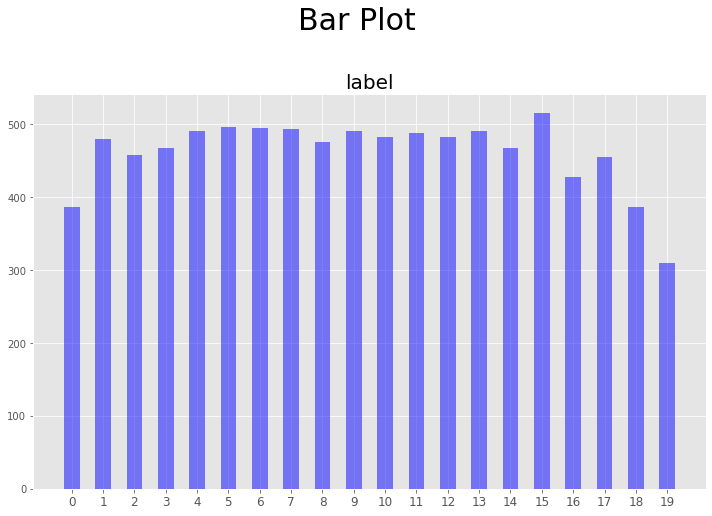

In [10]:
%matplotlib inline
plt.style.use('ggplot')

# 히스토그램을 사용해서 데이터 분포 확인
feature = train['target']

plt.figure(figsize = (10, 7.5)) # 그래프 이미지 크기 설정
plt.suptitle('Bar Plot', fontsize = 30) # 부제목과 폰트 크기 설정

plt.title('label', fontsize=20) # 제목과 폰트 크기 설정
temp = feature.value_counts() # feature 변수의 변수별 개수 계산
plt.bar(temp.keys(), temp.values, width = 0.5, color='b', alpha = 0.5) # 막대그래프 생성
plt.xticks(temp.keys(), fontsize=12) # x축 값, 폰트 크기 설정
plt.tight_layout(rect=[0, 0.03, 1, 0.95]) # 레이아웃 설정
plt.show() # 그래프 나타내기

## 7. 뉴스 text 길이 확인

In [11]:
str_len_mean = np.mean(train['text'].str.len()) # 리뷰 길이의 평균값 계산
print(f'뉴스의 평균 길이:', round(str_len_mean, 0))

뉴스의 평균 길이: 1020.0


In [15]:
# 데이터 필터링을 위한 마스크 설정
for i in range(0, 20):
    globals()['mask_{}'.format(i)] = (train.target == i)
    
# 전체 및 그룹 집합 설정
df_train = train.text.copy() # 전체 train 데이터

for i in range(0, 20):
    globals()['df_{}'.format(i)] = train.loc[globals()['mask_{}'.format(i)],:].text # 20가지 라벨 각각에 해당하는 데이터를 df0~19로 할당
    
# 스무가지로 나뉜 집합을 리스트로 묶음
compare = [df_0, df_1, df_2, df_3, df_4, df_5, 
           df_6, df_7, df_8, df_9, df_10, df_11,
           df_12, df_13, df_14, df_15, df_16, df_17,
           df_18, df_19]

In [ ]:
plt.figure(figsize=(40,20))
plt.suptitle("Histogram: news length", fontsize=40)
name = ['alt.atheism',
        'comp.graphics',
        'comp.os.ms-windows.misc',
        'comp.sys.ibm.pc.hardware',
        'comp.sys.mac.hardware',
        'comp.windows.x',
        'misc.forsale',
        'rec.autos',
        'rec.motorcycles',
        'rec.sport.baseball',
        'rec.sport.hockey',
        'sci.crypt',
        'sci.electronics',
        'sci.med',
        'sci.space',
        'soc.religion.christian',
        'talk.politics.guns',
        'talk.politics.mideast',
        'talk.politics.misc',
        'talk.religion.misc'] # 제목으로 사용할 문자열 (라벨의 실제 이름)

for i in range(len(compare)):
    text = compare[i]
    string_len = [len(x) for x in text]
    plt.subplot(5, 4, i+1) # 행 개수/ 열 개수/ 해당 그래프 표시 순서
    plt.title(name[i], fontsize=20)
    plt.axis([0, 50000, 0, 10])   # x축 시작, 끝 / y축 시작, 끝
    plt.hist(string_len, alpha=0.5, color='orange') # 히스토그램 생성, alpha: 그래프의 투명도 조절
    
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()